<a href="https://colab.research.google.com/github/alexisakov/RTPI/blob/master/Hard_numbers_Case_study_2_Real_time_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hard numbers. Case study 2: (Almost) real-time tracking

In [1]:
import requests
import numpy as np
import pandas as pd

Set up connection to the Hard Numbers API - you will need your API Key - reach us to get one: https://t.me/xiskv.

In [2]:
base_url='http://rtpiapi.hrdn.io/'

token = 'YOUR TOKEN'

request_headers = {'Authorization': f'Bearer {token}',
                    'Content-Type': 'application/json',
                    'Range-Unit': 'items'
                  }

For reference here is the Rosstat's current codebook: https://rosstat.gov.ru/storage/mediabank/j3LP7dsR/nabor_2020.xlsx

We choose white sugar for this example:

In [6]:
rosstat_id = 1601

request_url = base_url + f"rtpi_price_page?select=*&rosstat_id=eq.{rosstat_id}"

Now get the data:

In [9]:
response = requests.get(request_url, headers = request_headers).json()

We collect all the ids of the items, which have been classified as white sugar and make another request to the API - but now to the prices table:

In [62]:
ids = [x['web_price_id'] for x in response];
request_url =base_url + f"rtpi_price?select=*&web_price_id=in.{tuple(ids)}"
prices = requests.get(request_url, headers = request_headers).json()

Convert to the data frame, then pivot it so that product ids are now columns:

In [19]:
df = pd.DataFrame(prices)
pricedf = df.pivot(index='date_observe', columns='web_price_id', values=['current_price'])

Now - a bit of housekeeping - we convert index to date-time, resample to hourly frequecy, forward fill missing observations for 10 days:

In [63]:
pricedf.index = pd.to_datetime(pricedf.index)
pricedfh = pricedf.resample('H').max()
pricedfh = pricedfh.ffill(limit=10*24)

Let's see, what columns are available:

In [65]:
pricedfh.columns.values

array([('current_price', 126081), ('current_price', 126093),
       ('current_price', 138979), ('current_price', 139265),
       ('current_price', 139295), ('current_price', 139644),
       ('current_price', 139660), ('current_price', 162819),
       ('current_price', 335772), ('current_price', 335773),
       ('current_price', 335913), ('current_price', 335924),
       ('current_price', 335939), ('current_price', 2974674),
       ('current_price', 2975629), ('current_price', 2976532),
       ('current_price', 2978727), ('current_price', 3036781),
       ('current_price', 3415970), ('current_price', 3449488)],
      dtype=object)

So, now we can plot the corresponding data:

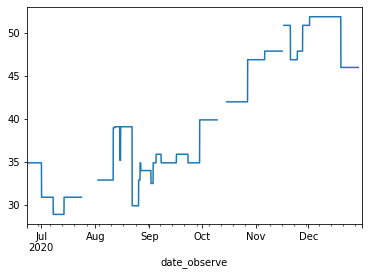

In [66]:
goodid = 139660;
pricedfh[('current_price',  goodid)].plot()

In case we want to understand the source of the id we can query the rtpi_price_page table:

In [ ]:
request_url = base_url + f"rtpi_price_page?select=*&web_price_id=eq.{goodid}"
requests.get(request_url, headers = request_headers).json()